# Анализ клиентов с неоптимальными тарифами

**Описание проекта**

Заказчик — провайдер виртуальной телефонии. Его клиенты — колл-центры, которые:
- распределяют входящие вызовы на операторов,
- совершают исходящие вызовы силами операторов.

Также операторы могут делать внутренние вызовы — вызовы друг между другом
внутри сети виртуальной телефонии.

**Задачи:**

- Найти клиентов, которые:

а) переплачивают на текущих тарифах;

б) сэкономят, если перейдут на более дорогой (по ежемесячной плате) тариф.
- Проанализировать изменения в выручке при переходе клиентов на оптимальные тарифы

**Правила формирования тарифов**

Ежемесячная плата за тариф:
- Тариф А — 4000 ₽,
- Тариф B — 2000 ₽,
- Тариф С — 1000 ₽.

Дополнительная ежемесячная плата за каждого оператора:
- Тариф А — 50 ₽,
- Тариф B — 150 ₽,
- Тариф С — 300 ₽.

Входящие звонки — бесплатны на всех тарифах

Исходящие звонки внутри сети, включённые в тариф:
- Тариф А — 2000 минут,
- Тариф B — 500 минут,
- Тариф С — нет.

Цена сверх лимита:
- A — 0.1 ₽/мин.,
- B — 0.15 ₽/мин.,
- C — 0.3 ₽/мин.

Исходящие звонки, кроме внутренних:
- A — 0.3 ₽/мин.,
- B — 0.5 ₽/мин.,
- C — 0.7 ₽/мин.

**Описание данных**
Датасет `/datasets/telecom_dataset.csv`

Колонки:
- `user_id` — идентификатор клиента;
- `date` — дата статистики;
- `direction` — направление вызовов: out — исходящий вызов, in — входящий;
- `internal` — маркер внутренних и внешних вызовов;
- `operator_id` — идентификатор оператора;
- `is_missed_call` — маркер пропущенных вызовов;
- `calls_count` — количество звонков;
- `call_duration` — длительность звонка без учёта времени ожидания;
- `total_call_duration` — длительность звонка с учётом времени ожидания.


Датасет `/datasets/telecom_clients.csv`

Колонки:
- `user_id` — идентификатор клиента;
- `tariff_plan` — тарифный план клиента;
- `date_start` — дата регистрации клиента в сервисе.

**Навигация по проекту**

[***1 Обзор и предобработка данных***](#1)

[***1.1 Загрузка и обзор данных***](#2)

[***1.2 Предобработка данных***](#3)

[***2 Исследовательский анализ данных***](#4)

[***2.1 Изучение и визуализация параметров***](#5)

[***2.2 Определение активных клиентов***](#6)

[***2.3 Подсчет расходов клиентов***](#7)

[***2.4 Анализ изменений при смене тарифа***](#8)

[***3 Проверка гипотез***](#9)

[***3.1 Первая гипотеза***](#10)

[***3.2 Вторая гипотеза***](#11)

[***4 Презентация***](#12)

[***5 Общий вывод***](#13)

## Обзор и предобработка данных <a id ='1'></a>

### Загрузка и обзор данных <a id ='2'></a>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')
import math as mth
import seaborn as sns
import pylab

sns.set_palette('pastel')

In [2]:
# загрузка данных
try:
    path = '/datasets/'
    data = pd.read_csv(path + 'telecom_dataset.csv')
    clients = pd.read_csv(path + 'telecom_clients.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv')
    clients = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_clients.csv')

Загрузив данные, изучим основную информацию по датасетам. Для этого создадим специальную функцию:

In [3]:
# функция для первичного анализа датасета
def df_info(df, n=5):
    ''' Данная функция проводит первичный анализ датасета, а именно: выводит первые n срок датасета,
        общую информацию о датасете,
        статистическую сводку, анализ количества пропусков и дубликатов.
        
        На вход функции подается датасет (аргумент df) и кол-во первых строк,
        которые следует вывести (аргумент n, по умолчанию 5)
    '''

    print(f'---------- Первые {n} строк датафрейма ----------')
    display(df.head(n))
    print('---------- Общая информация о датафрейме ----------\n')
    display(df.info())
    print('---------- Статистическая сводка ----------')
    display(df.describe())
    print('---------- Пропуски ----------')
    display(df.isna().sum().sort_values(ascending=False))
    print('---------- Процент пропусков от общего числа строк ----------')
    display(df.isna().mean().sort_values(ascending=False) * 100)
    if df.duplicated().sum() > 0:
        print(f'---------- Количество дубликатов: {df.duplicated().sum()} ----------')
        print('---------- Процент дубликатов от обшего кол-ва строк:',
              round(df.duplicated().sum() / len(df) * 100, 1), '----------')
    else:
        print('---------- Дубликаты отсутствуют ----------')

**Обзор датасета с информацией о звонках**

In [4]:
df_info(data, 10)

---------- Первые 10 строк датафрейма ----------


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62


---------- Общая информация о датафрейме ----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


None

---------- Статистическая сводка ----------


,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


---------- Пропуски ----------


operator_id            8172
internal                117
user_id                   0
date                      0
direction                 0
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

---------- Процент пропусков от общего числа строк ----------


operator_id            15.160847
internal                0.217061
user_id                 0.000000
date                    0.000000
direction               0.000000
is_missed_call          0.000000
calls_count             0.000000
call_duration           0.000000
total_call_duration     0.000000
dtype: float64

---------- Количество дубликатов: 4900 ----------
---------- Процент дубликатов от обшего кол-ва строк: 9.1 ----------


**Обзор датасета с информацией о клиентах**

In [5]:
df_info(clients)

---------- Первые 5 строк датафрейма ----------


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


---------- Общая информация о датафрейме ----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


None

---------- Статистическая сводка ----------


,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000


---------- Пропуски ----------


user_id        0
tariff_plan    0
date_start     0
dtype: int64

---------- Процент пропусков от общего числа строк ----------


user_id        0.0
tariff_plan    0.0
date_start     0.0
dtype: float64

---------- Дубликаты отсутствуют ----------


**Из обзора данных можно сделать следующие выводы:**

*Датафрейм с информацией о звонках*

- Всего в датафрейме 53902 строки и 9 столбцов;
- В столбцах с информацией о продолжительности звонков и о количестве звонков наблюдаются аномально большие значению по сравнению с медианой. Стоит рассмотреть внимательно эти столбцы и обработать аномалии;
- Наблюдаются пропуски в столбцах с информацией об id оператора (8172 пропуска, 15% от общ.) и о том, внешний или же внутренний это звонок (117 пропуской, 0,2% от общ.). Стоит подрбонее рассмотреть эти пропуски и обработать их;
- В датафрейме присустсвует 4900 дубликатов, что составляет 9,1 % от общ. Стоит рассмотреть и обработать данные дубликаты при необходимости;
- Столбец с информацией о дате стоит привести к нужному типу данных (datetime) и выделить дату, также столбец internal стоит привести к типу данных bool.

*Датафрейм с информацией о клиентах*

- Всего в датафрейме 732 строки и 3 столбца;
- Столбец с информацией о дате стоит привести к нужному типу данных (datetime);
- Пропуски отсутсвуют;
- Дубликаты отсутствуют.

### Предобработка данных<a id ='3'></a>


**Обработка дубликатов**

В датафрейме с информацией о вызовах наблюдается 4900 дубликатов, что составляет 9,1% от всех данных. Рассмотрим данные дубликаты подробнее и выясним, являются ли оно вообще дубликатами или же это такие же записи о звонках просто с одинаковым набором параметров

In [6]:
data[data.duplicated()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
44,166377,2019-08-14 00:00:00+03:00,out,False,880026.0,False,10,1567,1654
45,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
51,166377,2019-08-15 00:00:00+03:00,out,False,880026.0,False,11,1413,1473
...,...,...,...,...,...,...,...,...,...
53869,168601,2019-11-25 00:00:00+03:00,in,False,952914.0,False,7,1229,1282
53874,168601,2019-11-26 00:00:00+03:00,in,False,952914.0,False,4,539,562
53875,168601,2019-11-26 00:00:00+03:00,in,False,NaN,True,3,0,35
53885,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,True,3,0,89


Чтобы понять природу возникновения данных дубликатов,рассмотрим, нет ли какой-то зависимости возникновения дубликатов от клиента, оператора или даты

In [7]:
# количество уникальных значений в столбцах с инф. об id клиентов, операторов и даты
data[data.duplicated()][['user_id', 'date', 'operator_id']].nunique()

user_id        269
date           115
operator_id    776
dtype: int64

Можно отметить, что дубликаты никак не связаны с определенным клиентом, датой или операторами.

Теперь проверим, есть ли какая-то зависимость в повлении дубликатов от того, пропущенный ли это звонок, входящий или же внешний.

In [8]:
print('Распределение пропущенных и состоявшихся вызовов среди дубликатов:\n',
      data[data.duplicated()]['is_missed_call'].value_counts())

print('Распределение входящих и исходящих вызовов среди дубликатов:\n',
      data[data.duplicated()]['direction'].value_counts())

print('Распределение внешних и внутренних вызовов среди дубликатов:\n',
      data[data.duplicated()]['internal'].value_counts())

Распределение пропущенных и состоявшихся вызовов среди дубликатов:
 False    2785
True     2115
Name: is_missed_call, dtype: int64
Распределение входящих и исходящих вызовов среди дубликатов:
 out    2918
in     1982
Name: direction, dtype: int64
Распределение внешних и внутренних вызовов среди дубликатов:
 False    4382
True      511
Name: internal, dtype: int64


Можно отметить, что пропущенные и состоявшиеся вызовы распределены более-менее равномерно, во входящих и исходящих звонках тоже никакой значимой закономерности не наблюдается. Количество внешних звонок в дубликатах значительно превышает количество внутренних звонков, однако это можно объяснить тем, что в исходном датафрейме так же преобладают внешние звонки.

Стоит сделать вывод, что никакой зависимости ни к одному из параметров у наблюдаемых дубликатов нет,таблица сагрегирована, поэтому очистим ее от дубликатов.

In [9]:
# очищаем датафрейм от дубликатов
data = data.drop_duplicates()

data.duplicated().sum()

0

<div class="alert alert-success">
    
**Комментарий ревьюера**

**#ок**

Хорошо обоснованное решение, это всегда ценно в аналитическом проекте.
    
</div>

**Обработка пропусков**

В столбце `internal` датафрейма с информацией о звонках наблюдается 117 пропусков, что составляет 0,2% от всех данных. Рассмотрим эти пропуски поподробнее

In [10]:
data[data['internal'].isna()].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1007,166405,2019-09-18 00:00:00+03:00,in,NaN,NaN,True,1,0,59
1090,166405,2019-10-01 00:00:00+03:00,in,NaN,NaN,True,1,0,1
1864,166406,2019-08-20 00:00:00+03:00,in,NaN,NaN,True,1,0,36
1924,166406,2019-09-02 00:00:00+03:00,in,NaN,879898.0,False,1,2,9
6210,166541,2019-09-26 00:00:00+03:00,in,NaN,908960.0,False,1,393,423


Данные пропуски могут быть связаны с техническими ошибками. Без данных о том, внешний или внутренний был получен вызов, сложно будет анализировать распределение вызовов, а также проводить расчеты расходов клиентов. Пропуски в данном столбце составляют менее 1%, поэтому мы не рискуем потерять большое количество даннных при удалении пропущенных значений в столбце internal. Удалим пропуски

In [11]:
# удаляем пропуски в internal
data.dropna(subset=['internal'], inplace=True)

# смотрим оставшиеся пропуски
data.isna().sum().sort_values(ascending=False)

operator_id            7401
user_id                   0
date                      0
direction                 0
internal                  0
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

В столбце `operator_id` наблюдается 7401 пропусков (около 15% от общ.) Рассмотрим эти пропуски подробнее

In [12]:
data[data['operator_id'].isna()].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34


Пропуски в столбце с информацией об операторах могли появиться в тех случаях, когда оператора не назначили / не удалось назначить. Проверим это. Рассмотрим, какое-количество из вызовов без оператора являются пропущенными. Также узнаем, входящие или исходящие это вызовы в основном, внутренние или внешние.

In [13]:
print('Процент пропущенных вызовов с неопр. оператором от общего кол-ва строк с пропуском операторов:',
round(len(data[data['operator_id'].isna() & data['is_missed_call'] == True]) /
      len(data[data['operator_id'].isna()]) * 100, 1), '%')

print('Процент внешних вызовов с неопр. оператором от обшего кол-ва строк с пропуском операторов:',
round(len(data[(data['operator_id'].isna()) & (data['internal'] == False)]) /
      len(data[data['operator_id'].isna()]) * 100, 1), '%')

print('Процент входящих вызовов с неопр. оператором от обшего кол-ва строк с пропуском операторов:',
round(len(data[(data['operator_id'].isna()) & (data['direction'] == 'in')]) /
      len(data[data['operator_id'].isna()]) * 100, 1), '%')

Процент пропущенных вызовов с неопр. оператором от общего кол-ва строк с пропуском операторов: 98.5 %
Процент внешних вызовов с неопр. оператором от обшего кол-ва строк с пропуском операторов: 95.6 %
Процент входящих вызовов с неопр. оператором от обшего кол-ва строк с пропуском операторов: 97.5 %


Почти все вызовы с неопределенным оператором являются внешними, входящими и пропущенными. Вероятно, из-за того, что вызов является пропущенным, то оператор на него не назначается, а следовательно возникает пропуск в столбце operator_id. 

97,5% вызовов с неопределенным оператором являются входящими, а входящие звонки на всех тарифах бесплатные. Следовательно, данные пропуски никак не повлияют на расчет выручки, не исказят результаты, поэтому оставим эти записи, чтобы не потерять ~15% данных с другой полезной для анализа клиентов информацией о вызовах.

**Замена типов данных**

В датафрейме с информацией о вызовах стоит привести столбец с датой к правильному типу данных, оставив только дату. Также столбец internal стоит привести к типу данных bool.

В датафрейме с информацией о клиентах стоит привести столбец с датой к правильному типу данных, оставив только дату.

In [14]:
data['date'] = pd.to_datetime(data['date']).dt.date

data['internal'] = data['internal'].astype('bool')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              48892 non-null  int64  
 1   date                 48892 non-null  object 
 2   direction            48892 non-null  object 
 3   internal             48892 non-null  bool   
 4   operator_id          41491 non-null  float64
 5   is_missed_call       48892 non-null  bool   
 6   calls_count          48892 non-null  int64  
 7   call_duration        48892 non-null  int64  
 8   total_call_duration  48892 non-null  int64  
dtypes: bool(2), float64(1), int64(4), object(2)
memory usage: 3.1+ MB


In [15]:
clients['date_start'] = pd.to_datetime(clients['date_start']).dt.date

clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


**Вывод**

Во время предобработки данных было выполнено:

- Датафрейм с информацией о вызовах очищен от дубликатов. Пропуски в столбце iternal удалены, а в столбце operator_id оставлены (пропуски появляются, так как не назначается оператор для входящих пропущенных вызовов). Данные в столбце iternal приведены к типу данных bool, в столбце date - к datetime.date;
- В датафрейме с информацией о клиентах столбец date_start приведен к типу данных datetime.date

## Исследовательский анализ данных <a id ='4'></a>

### Изучение и визуализация параметров <a id ='5'></a>

**Определение активного периода исследования**

Для начала проверим, какой период данных нам задан в анализируемом датафрейме

In [16]:
print('Начало периода:', data['date'].min())
print('Конец периода:', data['date'].max())

Начало периода: 2019-08-02
Конец периода: 2019-11-28


Период, за который представлены данные: с августа до декабря 2019 года.

Рассматрим период, за который представлены данные о регистрации клиентов в сервисе

In [17]:
print('Начало периода:', clients['date_start'].min())
print('Конец периода:', clients['date_start'].max())

Начало периода: 2019-08-01
Конец периода: 2019-10-31


Последний день периода регистрации пользователей - 31 октября 2019 года, то есть нет клиентов, зарегистрировавшихся в декабре - значит, крайние активные клиенты прожили хотя бы месяц и мы сможем рассчитать их месячный комфортный расход услуг связи.

Рассмотрим, как распределены данные о звонках, не представлено ли периода с недостаточным количеством данных для объективного анализа и корректных выводов

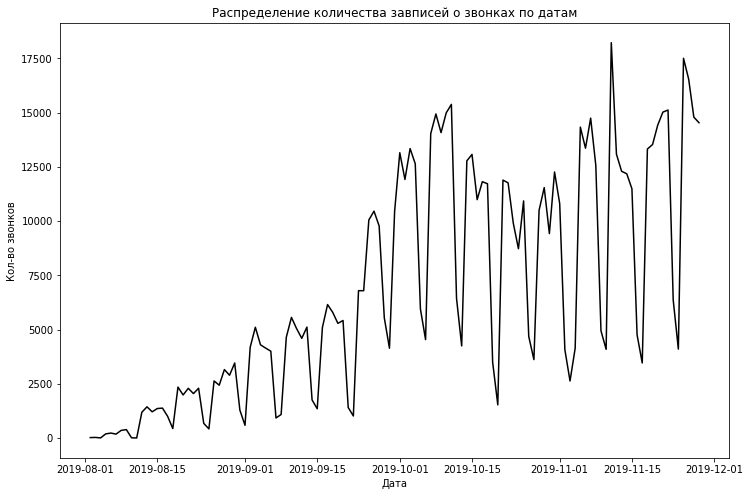

In [18]:
# суммируем количество звонков по датам и выводим график
data.groupby('date').agg({'calls_count':'sum'}).plot(figsize=(12,8), color='black', legend=False)

plt.title('Распределение количества завписей о звонках по датам')
plt.xlabel("Дата")
plt.ylabel("Кол-во звонков")

plt.show()

Судя по графику, количество звонков постепенно увеличивалось на протяжении всего периода. Незначительное снижение произошло только во второй половине октября и начале ноября, что может быть связано с сезонностью. Постоянный рост количества звонков может быть обусловлен увеличением числа крупных клиентов и преобладанием притока новых клиентов над оттоком.

Также стоит отметить регулярные снижения количества звонков в выходные дни, когда колл-центры либо не работают, либо работают в сокращённом режиме.

Заметим, что в августе было зафиксировано самое низкое количество звонков (почти весь месяц менее 2500 звонков в день). Это могло произойти из-за недостаточного сбора данных в начале периода или из-за постепенного наращивания клиентской базы провайдером.

В любом случае, такое небольшое количество данных за этот месяц может привести к некорректным выводам. Поэтому определим активный период как октябрь-декабрь 2019 года.


In [69]:
print('Доля данных, которая теряется при ограничении активного периода:',
      round(len(data[pd.to_datetime(data['date']).dt.month == 8]) / len(data) * 100, 1), '%')

# оставляем данные с сентября по декабрь
data = data[pd.to_datetime(data['date']).dt.month > 8]

data.head()

Доля данных, которая теряется при ограничении активного периода: 0.0 %


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
118,166377,2019-09-02,in,False,880028.0,False,2,66,75
119,166377,2019-09-02,in,False,880026.0,False,1,31,34
120,166377,2019-09-02,out,False,880026.0,False,16,1853,1983
121,166377,2019-09-02,out,False,880026.0,True,6,0,168
122,166377,2019-09-02,out,False,880028.0,False,20,2529,2687


При фильтрации данных по месяцу теряется всего 3,8% данных, что не исказит результаты анализа

**Анализ распределений параметров**

Рассмотрим, как распределены такие параметры как количество звонков и длительность звонков. Обработаем аномалии, если такие будут


Построим гистограмму с количеством звонков

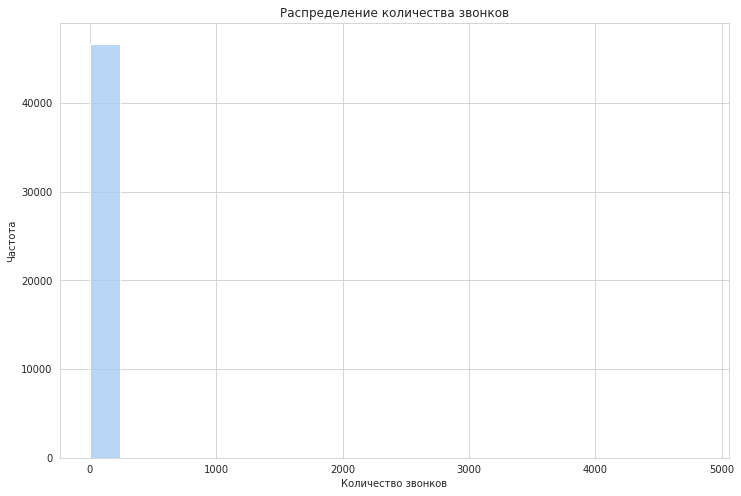

In [20]:
# размер графика
plt.figure(figsize=(12,8))

# стиль графиков
sns.set_style('whitegrid')

ax = sns.histplot(data['calls_count'], bins=20)

# подписи графику
ax.set_title('Распределение количества звонков')
ax.set_xlabel('Количество звонков')
ax.set_ylabel('Частота')

plt.show()

По графику сразу заметно, что есть большие выбросы. Ограничим график до 100 звонков в записи и посмотрим на распределение заново

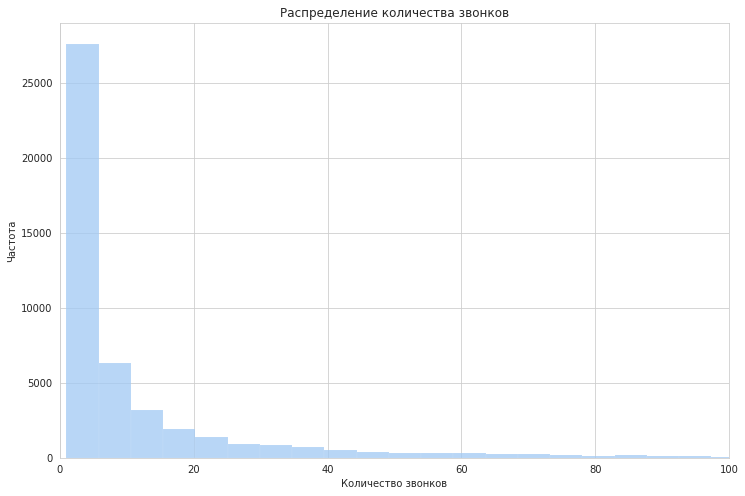

In [21]:
# размер графика
plt.figure(figsize=(12,8))

ax = sns.histplot(data['calls_count'], bins=1000)

# подписи графику
ax.set_title('Распределение количества звонков')
ax.set_xlabel('Количество звонков')
ax.set_ylabel('Частота')

plt.xlim(0, 100)
plt.show()

Даже при ограничении графика в 100 звонков на запись у графика распределения наблюдается длинный "хвост". Это говорит о наличии большого количества аномалий. 

Перед обработкой аномалий посмотрим на распределение продолжительности звонков

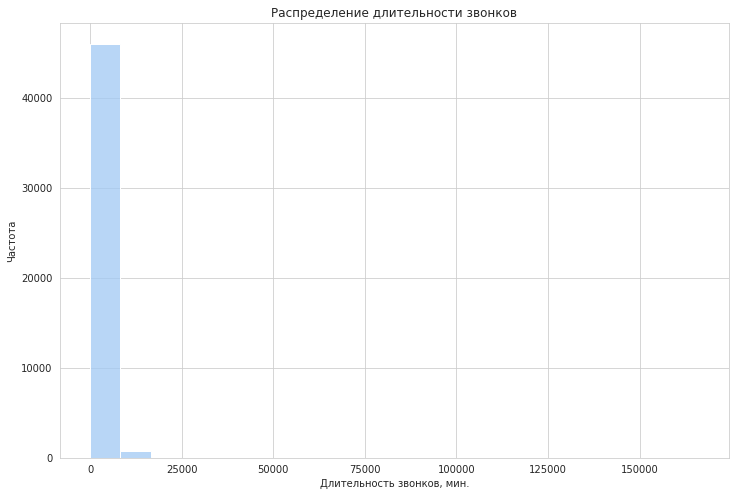

In [22]:
# размер графика
plt.figure(figsize=(12,8))

ax = sns.histplot(data['total_call_duration'], bins=20)

# подписи графику
ax.set_title('Распределение длительности звонков')
ax.set_xlabel('Длительность звонков, мин.')
ax.set_ylabel('Частота')

plt.show()

Здесь так же наблюдается большое количество выбросов. Присутсвуют продолжительности звонков даже более 125 000  мин. (~ 87 дней). Ограничим график до 10 000 мин. в день и посмотрим на распределение еще раз

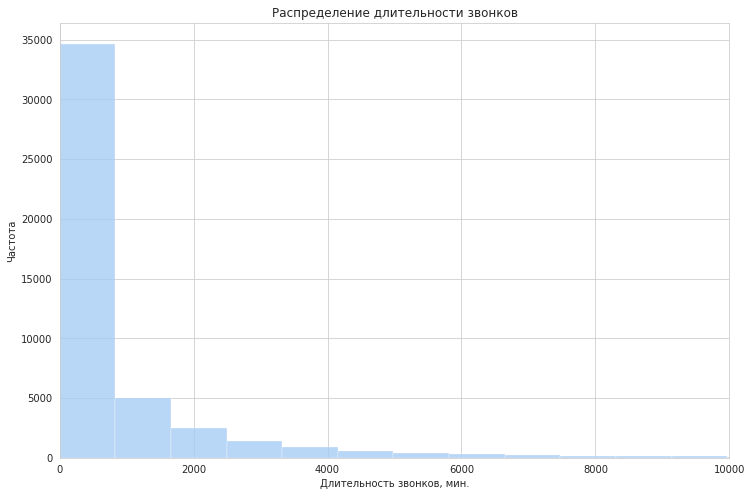

In [23]:
# размер графика
plt.figure(figsize=(12,8))

ax = sns.histplot(data['total_call_duration'], bins=200)

# подписи графику
ax.set_title('Распределение длительности звонков')
ax.set_xlabel('Длительность звонков, мин.')
ax.set_ylabel('Частота')

plt.xlim(0, 10000)
plt.show()

In [24]:
data[['calls_count', 'total_call_duration']].describe()

,calls_count,total_call_duration
count,47034.000000,47034.000000
mean,16.352639,1138.072288
std,63.708334,4338.346880
min,1.000000,0.000000
25%,1.000000,47.000000
50%,4.000000,212.000000
75%,12.000000,905.000000
max,4817.000000,166155.000000


В обоих рассматриваемых параметрах наблюдаются аномалии. Так в 75% записей о звонках совершается не более 12 звонков, при этом максимальное количество звонков - 4817. В 75% записей совершаются звонки длительностью не более 902 мин., при этом максимальная продолжительность - 166 155 мин.

Так как мы считаем, что данные выгружены корректно и только в минутах, то наличие аномалий можно объяснить следующими причинами:
- происходят сбои в закрытии смены операторов;
- через одну учетную запись работают сразу несколько операторов, то есть клиент идет на хитрость, чтобы не доплачивать за количество операторов. Данную ситуацию рекомендуется проверить и, возможно, пересмотреть либо средства защиты от таких действий, либо сами тарифные условия, чтобы у клиента не возникало стимулов экономить таким образом.

**Обработка аномалий**

Для того, чтобы не удалять большое количество важных данных о звонках, определим 95-й и 99-й перцентили столбцов с информацией о количестве и продолжительности звонков

In [25]:
for j in ['calls_count', 'total_call_duration']:
    print(f'95-й перцентиль столбца {j}: {round(np.percentile(data[j], [95, 99])[0])}')
    print(f'99-й перцентиль столбца {j}: {round(np.percentile(data[j], [95, 99])[1])}')

95-й перцентиль столбца calls_count: 62
99-й перцентиль столбца calls_count: 155
95-й перцентиль столбца total_call_duration: 4504
99-й перцентиль столбца total_call_duration: 12710


Очистим данные от больших аномалий: 
- оставим в датафрейме записи с количеством звонков менее 150, так мы удалим менее 5% данных
- оставим в датафрейме записи с продолжительностью звонков менее 8000, так мы удалим менее 5% данных

In [70]:
# максимальное кол-во звонков для очистки от аномалий
max_calls = 150
# максимальная продолжительность для очистки от аномалий
max_duration = 8000

# удаляем аномалии столбца calls_count
data_new = data.query('calls_count < @max_calls')

# удаляем аномалии столбца total_call_duration
data_new = data_new.query('total_call_duration < @max_duration')

print('Удалено данных относительно первоначального очищенного датафрейма:', round((1 - len(data_new)/len(data))*100, 1), '%')

Удалено данных относительно первоначального очищенного датафрейма: 2.6 %


Очистив данные от аномалий, мы потеряли менее 3% всех данных, что не исказит результаты анализа

**Анализ количества клиентов каждого тарифа**

Узнаем, сколько клиентов пользуется каждым из тарифов. Вывим наиболее популярный тариф у колл-центров

In [27]:
# объединим таблицу с данными о звонках и таблицей с данными о клиентах
data_tarif = data_new.merge(clients, on='user_id')

# проверим, правильно ли объединилось, получим общую информацию о новом дф
df_info(data_tarif)

---------- Первые 5 строк датафрейма ----------


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-09-02,in,False,880028.0,False,2,66,75,B,2019-08-01
1,166377,2019-09-02,in,False,880026.0,False,1,31,34,B,2019-08-01
2,166377,2019-09-02,out,False,880026.0,False,16,1853,1983,B,2019-08-01
3,166377,2019-09-02,out,False,880026.0,True,6,0,168,B,2019-08-01
4,166377,2019-09-02,out,False,880028.0,False,20,2529,2687,B,2019-08-01


---------- Общая информация о датафрейме ----------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45797 entries, 0 to 45796
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              45797 non-null  int64  
 1   date                 45797 non-null  object 
 2   direction            45797 non-null  object 
 3   internal             45797 non-null  bool   
 4   operator_id          38886 non-null  float64
 5   is_missed_call       45797 non-null  bool   
 6   calls_count          45797 non-null  int64  
 7   call_duration        45797 non-null  int64  
 8   total_call_duration  45797 non-null  int64  
 9   tariff_plan          45797 non-null  object 
 10  date_start           45797 non-null  object 
dtypes: bool(2), float64(1), int64(4), object(4)
memory usage: 3.6+ MB


None

---------- Статистическая сводка ----------


,user_id,operator_id,calls_count,call_duration,total_call_duration
count,45797.000000,38886.000000,45797.000000,45797.000000,45797.000000
mean,167312.776863,917392.380805,10.569819,530.811516,720.268598
std,588.449165,20789.983574,17.512985,1079.998309,1226.024568
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166839.000000,901880.000000,1.000000,0.000000,45.000000
50%,167176.000000,914842.000000,4.000000,35.000000,197.000000
75%,167827.000000,937736.000000,11.000000,519.000000,801.000000
max,168606.000000,973286.000000,149.000000,7811.000000,7999.000000


---------- Пропуски ----------


operator_id            6911
user_id                   0
date                      0
direction                 0
internal                  0
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
tariff_plan               0
date_start                0
dtype: int64

---------- Процент пропусков от общего числа строк ----------


operator_id            15.090508
user_id                 0.000000
date                    0.000000
direction               0.000000
internal                0.000000
is_missed_call          0.000000
calls_count             0.000000
call_duration           0.000000
total_call_duration     0.000000
tariff_plan             0.000000
date_start              0.000000
dtype: float64

---------- Дубликаты отсутствуют ----------


Датасеты объединились корректно, теперь посчитаем, сколько клиентов пользуется каждым из тарифов

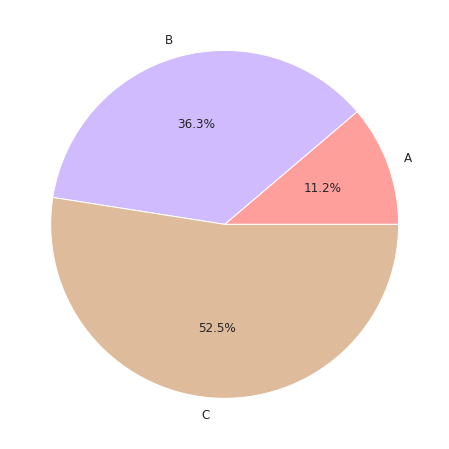

In [28]:
# размер
plt.figure(figsize=(12, 8))

# круговая диаграмма по сводной таблице с количеством уникальных пользователей по каждому из тарифов
plt.pie(data_tarif.pivot_table(index='tariff_plan', values='user_id', aggfunc='nunique').reset_index()['user_id'],
        labels = ['A', 'B', 'C'],
        autopct='%.1f%%',
        textprops={'size': 'large'},
        colors = sns.color_palette('pastel')[3:6])

plt.show()

Cамый популярный тариф - С, им пользуются больше половины всех пользователей (52,4%) - это самый номинально дешевый тариф. Самым непопулярным тарифом является тариф А - он самый дорогой - им пользуются 11% всех пользователей.


### Определение активных клиентов <a id ='6'></a>

Определим активных клиентов. Для этого рассчитаем последнюю дату активности у каждого клиента. Сравним эту дату с последней датой в периоде. Будем считать клиента неактивным, если он не совершал звонков в течение 15 дней

In [29]:
# дф с информацией об активности пользователей
# для каждого пользователя рассчитываем крайнюю дату активности
activity = data_tarif.groupby('user_id').agg(last_date=('date', 'last')).reset_index()

# последняя дата наблюдений
max_date = data['date'].max()

# задаем границу - через сколько дней без активности пользователя можно считать неактивным
day_wo_act = 15

# от последней даты наблюдений отнимаем последнюю дату активности пользователя
# и сравниваем получившееся кол-во дней без активности с границей
activity['is_active'] = (max_date - activity['last_date']).dt.days < day_wo_act

# добавляем столбец с информацией об активности пользователя в основной дф
data_tarif = data_tarif.merge(activity[['user_id', 'is_active']], on='user_id')

display(data_tarif.head(5))
print('Количество неактивных пользователей:', len(activity.query('is_active == False')))

print('Процент неактивных пользователей от всех:',
      round(len(activity.query('is_active == False')) / len(activity) * 100, 1), '%')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,is_active
0,166377,2019-09-02,in,False,880028.0,False,2,66,75,B,2019-08-01,True
1,166377,2019-09-02,in,False,880026.0,False,1,31,34,B,2019-08-01,True
2,166377,2019-09-02,out,False,880026.0,False,16,1853,1983,B,2019-08-01,True
3,166377,2019-09-02,out,False,880026.0,True,6,0,168,B,2019-08-01,True
4,166377,2019-09-02,out,False,880028.0,False,20,2529,2687,B,2019-08-01,True


Количество неактивных пользователей: 56
Процент неактивных пользователей от всех: 18.5 %


Для дальнейшего анализ оставим только активных пользователей в датафрейме, так как предлагать сменить тариф неактивным пользователям нет смылса. Также добавим в датафрейм столбец с информацией о номере месяца для удобства дальнейшего анализа

In [30]:
# активные пользователи
data_act = data_tarif[data_tarif['is_active'] == True]

# столбец с информацией о месяце
data_act['month'] = pd.to_datetime(data_act['date']).dt.month

data_act.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,is_active,month
0,166377,2019-09-02,in,False,880028.0,False,2,66,75,B,2019-08-01,True,9
1,166377,2019-09-02,in,False,880026.0,False,1,31,34,B,2019-08-01,True,9
2,166377,2019-09-02,out,False,880026.0,False,16,1853,1983,B,2019-08-01,True,9
3,166377,2019-09-02,out,False,880026.0,True,6,0,168,B,2019-08-01,True,9
4,166377,2019-09-02,out,False,880028.0,False,20,2529,2687,B,2019-08-01,True,9


Создадим датафрейм с информацией о тарифах и параметрах каждого из тарифов:

- `tariff_plan` - тарифный план, название;
- `monthly` - ежемесячная плата за тариф;
- `limit` - исходящие звонки внутри сети, включенные в тариф;
- `up_limit` - цена сверх лимита;
- `if_not_internal` - исходящие звонки, кроме внутренних;
- `per_operator` - дополнительная ежемесячная плата за каждого оператора.

In [31]:
# дф с информацией о тарифах
tarifs = pd.DataFrame({'tariff_plan':['A', 'B', 'C'],
     'monthly':[4000, 2000, 1000],
     'limit':[2000, 500, 0],
     'up_limit':[0.1, 0.15, 0.3],
     'if_not_internal':[0.3, 0.5, 0.7],
      'per_operator': [50, 150, 300]})

tarifs

,tariff_plan,monthly,limit,up_limit,if_not_internal,per_operator
0,A,4000,2000,0.10,0.3,50
1,B,2000,500,0.15,0.5,150
2,C,1000,0,0.30,0.7,300


### Подсчет расходов клиентов<a id ='7'></a>

**Расходы клиентов на текущем тарифе**

Для того, чтобы рассчитать расходы клиентов, узнаем у каждого клиента по месяцам:
- кол-во операторов;
- общую продолжительность исходящих звонков внутри сети;
- общую продолжительность исходящих звонков вне сети.

Для этого будет группировать пользователей по id и месяцу, а затем вычислять уникальное количество операторов, общую продолжительность звонков внутри и вне сети.

In [32]:
# количество операторов у каждого клиента по месяцам
payment = data_act.groupby(['user_id', 'month']).agg(tariff_plan=('tariff_plan','first'),
                                                     operators=('operator_id', 'nunique')).reset_index()

payment.head()

,user_id,month,tariff_plan,operators
0,166377,9,B,4
1,166377,10,B,5
2,166377,11,B,4
3,166391,9,C,1
4,166391,10,C,0


In [33]:
# общая продолжительность исходящих звонков внутри сети у каждого клиента по месяцам
mins_lim = (data_act.query('(internal == True) & (direction == "out")')
        .groupby(['user_id', 'month'])
        .agg(limit_min=('total_call_duration', 'sum'))
        .reset_index()
       )

mins_lim.head()

,user_id,month,limit_min
0,166377,9,9
1,166377,10,5
2,166377,11,127
3,166405,10,778
4,166405,11,115


In [34]:
# присоединяем информацию о звонках к датафрейму с информацией об операторах
payment = payment.merge(mins_lim, on=['user_id', 'month'], how='left')

# заполняем пропуски нулями у тех поьзователей, которые не совершали исходящих звонков внутри сети
payment['limit_min'] = (payment['limit_min'].fillna(0)).astype('int')

payment.head()

,user_id,month,tariff_plan,operators,limit_min
0,166377,9,B,4,9
1,166377,10,B,5,5
2,166377,11,B,4,127
3,166391,9,C,1,0
4,166391,10,C,0,0


In [35]:
# общая продолжительность исходящих звонков вне сети у каждого клиента по месяцам
mins_ni = (data_act.query('(internal == False) & (direction == "out")')
        .groupby(['user_id', 'month'])
        .agg(min_ni=('total_call_duration', 'sum'))
        .reset_index()
       )

mins_ni.head()

,user_id,month,min_ni
0,166377,9,105835
1,166377,10,99207
2,166377,11,95384
3,166405,9,120743
4,166405,10,232832


In [36]:
# присоединяем к датафрейму с информаией об операторах и минутах внутри сети
payment = payment.merge(mins_ni, on=['user_id', 'month'], how='left')

# заполняем пропуски нулями у тех пользователей, которые не совершали звонки вне сети
payment['min_ni'] = (payment['min_ni'].fillna(0)).astype('int')

payment.head()

,user_id,month,tariff_plan,operators,limit_min,min_ni
0,166377,9,B,4,9,105835
1,166377,10,B,5,5,99207
2,166377,11,B,4,127,95384
3,166391,9,C,1,0,0
4,166391,10,C,0,0,0


Получился датафрейм `payment` с информацией об общих тратах по тарифам у каждого клиента по месяцам. Для того, чтобы рассчитать расходы у клиентов, присоединим к этому датафрейму таблицу с параметрами каждого из тарифов `tarifs`

In [37]:
# соединяем таблицы по тарифным планам
payment = payment.merge(tarifs, on='tariff_plan')

payment.head()

,user_id,month,tariff_plan,operators,limit_min,min_ni,monthly,limit,up_limit,if_not_internal,per_operator
0,166377,9,B,4,9,105835,2000,500,0.15,0.5,150
1,166377,10,B,5,5,99207,2000,500,0.15,0.5,150
2,166377,11,B,4,127,95384,2000,500,0.15,0.5,150
3,166405,9,B,4,0,120743,2000,500,0.15,0.5,150
4,166405,10,B,10,778,232832,2000,500,0.15,0.5,150


Расходы клиента состоят из:
1. ежемесячной платы +
2. платы за перерасход по внутренним исходящим звонкам, с учетом времени ожидания +
3. платы за внешние исходящие звонки с учетом времени ожидания +
4. платы за операторов.

Для того, чтобы посчитать расходы клиента, создадим функцию

In [38]:
def result(row):
    '''Ф-я считает расходы клиентов по каждому из тарифов в соответствии с параметрами тарифов.
    
    На вход подается строка датафрейма - row. В row['result'] сначала суммируется ежемесячная плата, плата за операторов
    и плата за звонки вне сети. Затем, если общая прод-ть звонков клиента за месяц превышает лимит по тарифу,
    то к row['result'] прибавляется плата за перерасход исходящих внутренних звонков'''
    
    row['result'] = row['monthly'] + row['operators'] * row['per_operator'] + row['min_ni'] * row['if_not_internal']
    
    if (row['limit_min'] - row['limit']) > 0:
        return row['result'] + (row['limit_min'] - row['limit']) * row['up_limit']
    return row['result']
    

In [39]:
# расчет расходов клиента на текущем тарифе
payment['current_tarif'] = payment.apply(result, axis=1)

payment.head()

,user_id,month,tariff_plan,operators,limit_min,min_ni,monthly,limit,up_limit,if_not_internal,per_operator,current_tarif
0,166377,9,B,4,9,105835,2000,500,0.15,0.5,150,55517.5
1,166377,10,B,5,5,99207,2000,500,0.15,0.5,150,52353.5
2,166377,11,B,4,127,95384,2000,500,0.15,0.5,150,50292.0
3,166405,9,B,4,0,120743,2000,500,0.15,0.5,150,62971.5
4,166405,10,B,10,778,232832,2000,500,0.15,0.5,150,119957.7


Рассчитаем выручку за анализируемый период по активным клиентам, а также динамику среднего чека по месяцам

In [40]:
print('Всего выручка за анализируемый период:', round(payment['current_tarif'].sum()))

Всего выручка за анализируемый период: 10734707


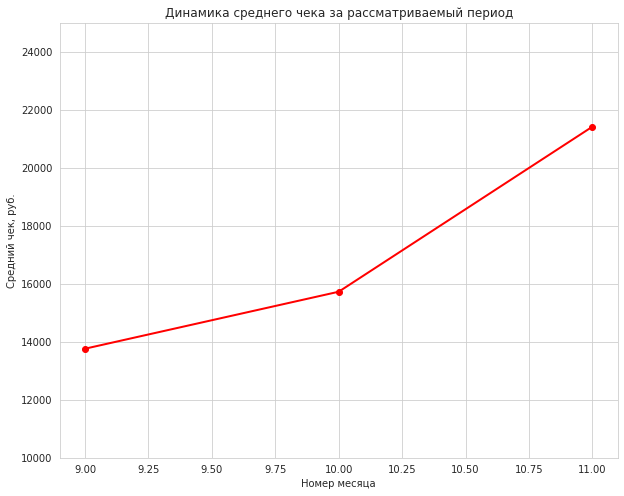

In [41]:
payment.groupby('month').agg(avg_month_rev=('current_tarif', 'mean')).plot(style='o-',
                                                                           linewidth=2,
                                                                           legend=False,
                                                                           figsize=(10,8),
                                                                           color='red');

plt.title('Динамика среднего чека за рассматриваемый период')
plt.xlabel('Номер месяца')
plt.ylabel('Средний чек, руб.')
plt.ylim(10000, 25000)
plt.show()

Судя по графику, средний чек за рассматриваемый период увеличивается (с примерно 14 000 рублей в сентябре до примерно 22 000 в ноябре). Это может объясняться тем, что среди клиентов наблюдаются крупные клиенты, которые расходуют огромное количество услуг связи, что приводит к «выбросам» в статистике.

Чтобы получить более точную картину, рассмотрим средние чеки по месяцам с помощью боксплотов отдельно для разных тарифов.

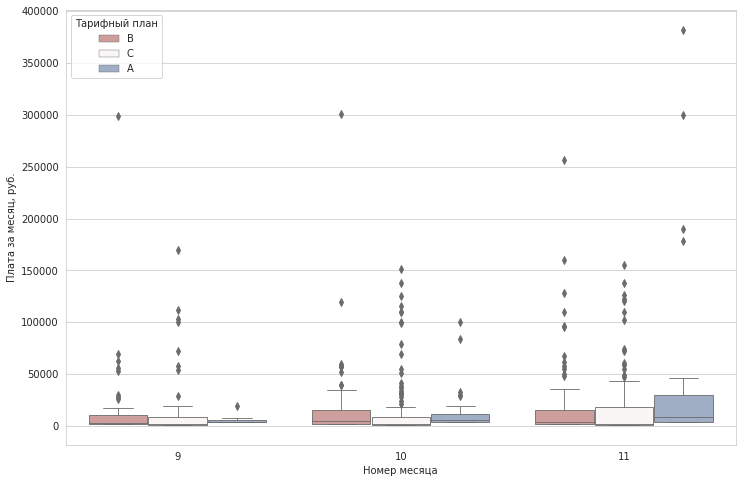

In [42]:
plt.figure(figsize=(12,8))

sns.boxplot(data=payment,
            x='month',
            y='current_tarif',
            hue='tariff_plan',
            linewidth=.85,
            palette='vlag_r',
            saturation=.8)

plt.legend(title='Тарифный план')
plt.xlabel('Номер месяца')
plt.ylabel('Плата за месяц, руб.')
plt.show()

На графике действительно видны необычно большие суммы оплаты услуг связи в месяц (100 000 - 400 000 руб.). Такие аномалии встречаются на протяжении всего рассматриваемого периода, но особенно большие заметны в ноябре.

Не будем удалять эти выбросы, поскольку такие суммы оплаты могут действительно быть у особо крупных клиентов. Однако ограничимся максимальным значением по оси Y до 50 000 рублей в месяц, чтобы рассмотреть боксплоты лучше

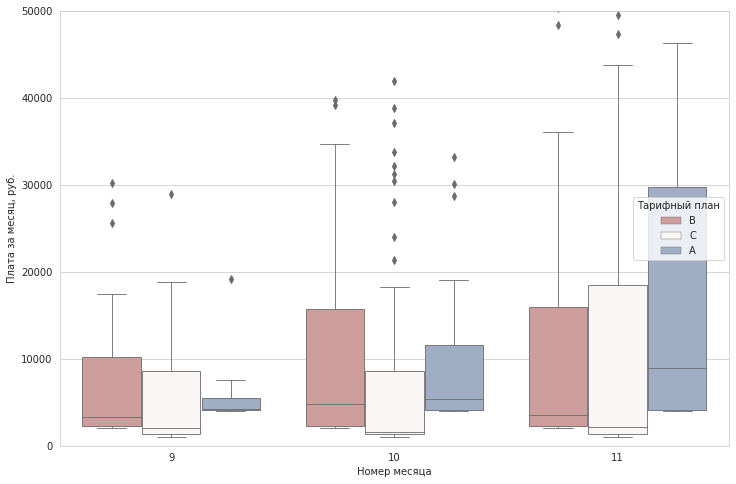

In [43]:
plt.figure(figsize=(12,8))

sns.boxplot(data=payment,
            x='month',
            y='current_tarif',
            hue='tariff_plan',
            linewidth=.85,
            palette='vlag_r',
            saturation=.8)

plt.legend(title='Тарифный план')
plt.xlabel('Номер месяца')
plt.ylabel('Плата за месяц, руб.')
plt.ylim(0, 50000)
plt.show()

В целом можно отметить положительную динамику: средний чек по тарифам за рассматриваемый период увеличивается. Самый низкий средний чек наблюдается по тарифу C, а самый высокий — по тарифу A.

В ноябре особенно заметно отклонение от медианного значения по тарифу A. Это может указывать на наличие клиентов, которые тратят на услуги связи особенно большие суммы. Также отклонения от медианы наблюдаются и по тарифам B и C на протяжении всего периода. Это может свидетельствовать о том, что среди клиентов этих тарифов есть те, кто платит большие суммы за услуги свзяи. Возможно, эти клиенты смогут сэкономить, перейдя на более выгодный тариф, который лучше подходит для клиентов с большими расходами на звонки и большим количеством операторов в колл-центре.

**Расходы клиентов на каждом из тарифов**

Рассчитаем, сколько бы платили клиенты на каждом из тарифов при том же расходе минут, при том же кол-ве операторов в колл-центре. Для этого создадим функцию, а затем добавим в датафрейм столбцы с расходами по каждому тарифу 

In [44]:
def pay_per_tarif(row, tariff_plan):
    '''Ф-я подсчитывает затраты клиентов на указанном тарифе по подсчитанным расходам услуг связи (минуты, кол-во операторов)
    
    Передается строка датафрейма - row и тарифный план, по которому рассчитываются затраты - tariff_plan.
    При передачи параметров по тарифу ссылается на таблицу tarifs.'''
    
    tarif = tarifs[tarifs['tariff_plan'] == tariff_plan].iloc[0]
    
    row['res'] = tarif['monthly'] + row['operators'] * tarif['per_operator'] + row['min_ni'] * tarif['if_not_internal']
    
    if row['limit_min'] > tarif['limit']:
        row['res'] = row['res'] + (row['limit_min'] - tarif['limit']) * tarif['up_limit']
        
    return row['res']

In [45]:
# расходы по тарифу А
payment['A'] = payment.apply(pay_per_tarif, axis=1, args=('A'))

# расходы по тарифу В
payment['B'] = payment.apply(pay_per_tarif, axis=1, args=('B'))

# расходы по тарифу С
payment['C'] = payment.apply(pay_per_tarif, axis=1, args=('C'))

payment.head()

,user_id,month,tariff_plan,operators,limit_min,min_ni,monthly,limit,up_limit,if_not_internal,per_operator,current_tarif,A,B,C
0,166377,9,B,4,9,105835,2000,500,0.15,0.5,150,55517.5,35950.5,55517.5,76287.2
1,166377,10,B,5,5,99207,2000,500,0.15,0.5,150,52353.5,34012.1,52353.5,71946.4
2,166377,11,B,4,127,95384,2000,500,0.15,0.5,150,50292.0,32815.2,50292.0,69006.9
3,166405,9,B,4,0,120743,2000,500,0.15,0.5,150,62971.5,40422.9,62971.5,86720.1
4,166405,10,B,10,778,232832,2000,500,0.15,0.5,150,119957.7,74349.6,119957.7,167215.8


**Определим оптимальный тариф для каждого клиента** Для этого суммируем затраты пользователей по каждому из тарифов за весь анализируемый период. Затем сравним расходы по каждому из тарифов. Оптммальным будет тот тариф, за который сумма расходов за все время будет наименьшей

In [46]:
# группируем по пользователям и суммируем затраты за весь период
payment_pivot = payment.groupby('user_id').agg({'tariff_plan':'first',
                               'current_tarif': 'sum',
                               'A':'sum',
                               'B':'sum',
                               'C':'sum',
                               'month':'count'}).reset_index()

payment_pivot.head()

,user_id,tariff_plan,current_tarif,A,B,C,month
0,166377,B,158163.0,102777.8,158163.0,217240.5,3
1,166391,C,3600.0,12100.0,6300.0,3600.0,3
2,166392,C,4800.0,12300.0,6900.0,4800.0,3
3,166405,B,342815.7,213184.4,342815.7,476731.5,3
4,166406,B,137032.6,90351.3,137032.6,187172.3,3


In [47]:
# навзвание оптимального тарифа
payment_pivot['optimal_tarif'] = payment_pivot[['A', 'B', 'C']].idxmin(axis=1)

# расходы на оптимальном тарифе
payment_pivot['optimal_pay'] = payment_pivot[['A', 'B', 'C']].min(axis=1)

payment_pivot.head()

,user_id,tariff_plan,current_tarif,A,B,C,month,optimal_tarif,optimal_pay
0,166377,B,158163.0,102777.8,158163.0,217240.5,3,A,102777.8
1,166391,C,3600.0,12100.0,6300.0,3600.0,3,C,3600.0
2,166392,C,4800.0,12300.0,6900.0,4800.0,3,C,4800.0
3,166405,B,342815.7,213184.4,342815.7,476731.5,3,A,213184.4
4,166406,B,137032.6,90351.3,137032.6,187172.3,3,A,90351.3


Рассчитаем, сколько клиент переплатил по текущему тарифу по сравнению с оптимальным

In [48]:
# переплата
payment_pivot['overpayment'] = payment_pivot['current_tarif'] - payment_pivot['optimal_pay']

payment_pivot.head()

,user_id,tariff_plan,current_tarif,A,B,C,month,optimal_tarif,optimal_pay,overpayment
0,166377,B,158163.0,102777.8,158163.0,217240.5,3,A,102777.8,55385.2
1,166391,C,3600.0,12100.0,6300.0,3600.0,3,C,3600.0,0.0
2,166392,C,4800.0,12300.0,6900.0,4800.0,3,C,4800.0,0.0
3,166405,B,342815.7,213184.4,342815.7,476731.5,3,A,213184.4,129631.3
4,166406,B,137032.6,90351.3,137032.6,187172.3,3,A,90351.3,46681.3


**Кому предлагаем перейти на оптимальный тариф?**

Так как переплата может составлять всего 5-10 рублей, то в таком случае нет смысла предлагать пользователям сменить тариф.

Будем предлагать сменить тариф тем пользователям, у которых переплата на текущем тарифе составляет 5% или более от текущего тарифа. Минимизирование издержек в бизнесе - одна из главных целей, поэтому граница в 5% уже будет значима (особенно для групных клиентов).

Также стоит учитывать, что предлагать смену тарифа следует клиентам, которые пользуются услугами связи более месяца. За один месяц мы не можем точно определить, действительно ли клиент переплачивает. Возможно, колл-центр только начинает свою работу и собирает базу номеров, делает небольшое количество звонков. В последующие месяцы работа может быть более активной, и предложенный тариф уже не будет оптимальным.

In [49]:
# на сколько процентов оптимальный тариф должен превышать действующий для того,
# чтобы было целесообразно предложить клиенту новый тариф
perc = 0.05

# оптимальный тариф или нет, будем предлагать сменить тариф или нет
payment_pivot['is_not_optimal'] = ((payment_pivot['overpayment']
                                   >= payment_pivot['current_tarif'] * perc)
                                   & (payment_pivot['month'] > 1))

payment_pivot.head()

,user_id,tariff_plan,current_tarif,A,B,C,month,optimal_tarif,optimal_pay,overpayment,is_not_optimal
0,166377,B,158163.0,102777.8,158163.0,217240.5,3,A,102777.8,55385.2,True
1,166391,C,3600.0,12100.0,6300.0,3600.0,3,C,3600.0,0.0,False
2,166392,C,4800.0,12300.0,6900.0,4800.0,3,C,4800.0,0.0,False
3,166405,B,342815.7,213184.4,342815.7,476731.5,3,A,213184.4,129631.3,True
4,166406,B,137032.6,90351.3,137032.6,187172.3,3,A,90351.3,46681.3,True


In [50]:
# для удобства уберем из дф информацию о расходах на всех тарифах и переплате
payment_pivot = payment_pivot[['user_id',
                               'month',
                               'tariff_plan',
                               'optimal_tarif',
                               'current_tarif',
                               'optimal_pay',
                               'is_not_optimal']]

payment_pivot.head()

,user_id,month,tariff_plan,optimal_tarif,current_tarif,optimal_pay,is_not_optimal
0,166377,3,B,A,158163.0,102777.8,True
1,166391,3,C,C,3600.0,3600.0,False
2,166392,3,C,C,4800.0,4800.0,False
3,166405,3,B,A,342815.7,213184.4,True
4,166406,3,B,A,137032.6,90351.3,True


In [51]:
print('Количество пользователей с неоптимальными тарифами:', len(payment_pivot[payment_pivot['is_not_optimal'] == True]))
print('Процент пользователей с неоптимальными тарифами:',
      round(len(payment_pivot[payment_pivot['is_not_optimal'] == True]) / len(payment_pivot) * 100, 1), '%')

Количество пользователей с неоптимальными тарифами: 121
Процент пользователей с неоптимальными тарифами: 49.0 %


Создадим столбцы с тарифами после оптимизации, которая провелась только для тех клиентов с неоптимальными тарифами, которые переплачивали более 5% на тек. тарифе и которые пользуются сервисом более месяца

In [52]:
def optimization(row):
    '''Ф-я возвращает оптимальную плату за тариф, если тариф не оптимальный
    На вход подается строка датафрейма'''
    
    if row['is_not_optimal']:
        return row['optimal_pay']
    return row['current_tarif']

def optimization_tar(row):
    '''Ф-я возвращает название оптимального тарифа
    На вход подается строка датафрейма'''
    
    if row['is_not_optimal']:
        return row['optimal_tarif']
    return row['tariff_plan']

In [53]:
# плата после оптимизации
payment_pivot['after_opt'] = payment_pivot.apply(optimization, axis=1)

# тариф после оптимизации
payment_pivot['after_opt_tarif'] = payment_pivot.apply(optimization_tar, axis=1)

payment_pivot.head()

,user_id,month,tariff_plan,optimal_tarif,current_tarif,optimal_pay,is_not_optimal,after_opt,after_opt_tarif
0,166377,3,B,A,158163.0,102777.8,True,102777.8,A
1,166391,3,C,C,3600.0,3600.0,False,3600.0,C
2,166392,3,C,C,4800.0,4800.0,False,4800.0,C
3,166405,3,B,A,342815.7,213184.4,True,213184.4,A
4,166406,3,B,A,137032.6,90351.3,True,90351.3,A


In [54]:
# оставляем в датафрейме только id клиента, кол-во месяцев в сервисе, текущий тар. плани плата за него,
# тар. план после оптимизации и плата за него
payment_res = payment_pivot[['user_id', 'month', 'tariff_plan', 'current_tarif', 'after_opt_tarif', 'after_opt']]

payment_res.head()

,user_id,month,tariff_plan,current_tarif,after_opt_tarif,after_opt
0,166377,3,B,158163.0,A,102777.8
1,166391,3,C,3600.0,C,3600.0
2,166392,3,C,4800.0,C,4800.0
3,166405,3,B,342815.7,A,213184.4
4,166406,3,B,137032.6,A,90351.3


Для того, чтобы был возможен анализ и визуализация по месяцам, перенесем информацию об оптимальном тарифе в датафрейм с данными по месяцам

In [55]:
# оптимальный тариф по месяцам
payment_monthly = (payment[['user_id',
                            'month',
                            'tariff_plan',
                            'current_tarif',
                            'A', 'B', 'C']]
                   .merge(payment_res[['user_id',
                                       'after_opt_tarif']],
                          on='user_id'))


payment_monthly.head()

,user_id,month,tariff_plan,current_tarif,A,B,C,after_opt_tarif
0,166377,9,B,55517.5,35950.5,55517.5,76287.2,A
1,166377,10,B,52353.5,34012.1,52353.5,71946.4,A
2,166377,11,B,50292.0,32815.2,50292.0,69006.9,A
3,166405,9,B,62971.5,40422.9,62971.5,86720.1,A
4,166405,10,B,119957.7,74349.6,119957.7,167215.8,A


In [56]:
def choice_tarif(row):
    '''Ф-я, которая возвращает плату по оптимальному тарифу
    На вход подается строка датафрейма'''
    
    if row['after_opt_tarif'] == 'A':
        return row['A']
    elif row['after_opt_tarif'] == 'B':
        return row['B']
    return row['C']

In [57]:
# оплата после оптимизации
payment_monthly['after_opt'] = payment_monthly.apply(choice_tarif, axis=1)

payment_monthly.head()

,user_id,month,tariff_plan,current_tarif,A,B,C,after_opt_tarif,after_opt
0,166377,9,B,55517.5,35950.5,55517.5,76287.2,A,35950.5
1,166377,10,B,52353.5,34012.1,52353.5,71946.4,A,34012.1
2,166377,11,B,50292.0,32815.2,50292.0,69006.9,A,32815.2
3,166405,9,B,62971.5,40422.9,62971.5,86720.1,A,40422.9
4,166405,10,B,119957.7,74349.6,119957.7,167215.8,A,74349.6


**Выводы**
- Расходы клиентов имею положительную тенденцию роста на протяжении всего рассматриваемого периода;
- самый низкий средний чек наблюдается по тарифу C, самый высокий — по тарифу A.
- выручка за анализируемый период по текущим тарифам составила 10 734 707 руб.
- количество пользователей с неоптимальными тарифами 121 (49% от всех активных пользователей).

### Анализ изменений при смене тарифа <a id ='8'></a>


**Расходы клиентов до/после оптимизации**

In [58]:
# средняя плата в месяц до оптимизации по клиентам
payment_res['monthly_before'] = round(payment_res['current_tarif'] / payment_res['month'], 1)

# средняя плата в месяц после оптимизации по клиентам
payment_res['monthly_after'] = round(payment_res['after_opt'] / payment_res['month'], 1)

payment_res.head()

,user_id,month,tariff_plan,current_tarif,after_opt_tarif,after_opt,monthly_before,monthly_after
0,166377,3,B,158163.0,A,102777.8,52721.0,34259.3
1,166391,3,C,3600.0,C,3600.0,1200.0,1200.0
2,166392,3,C,4800.0,C,4800.0,1600.0,1600.0
3,166405,3,B,342815.7,A,213184.4,114271.9,71061.5
4,166406,3,B,137032.6,A,90351.3,45677.5,30117.1


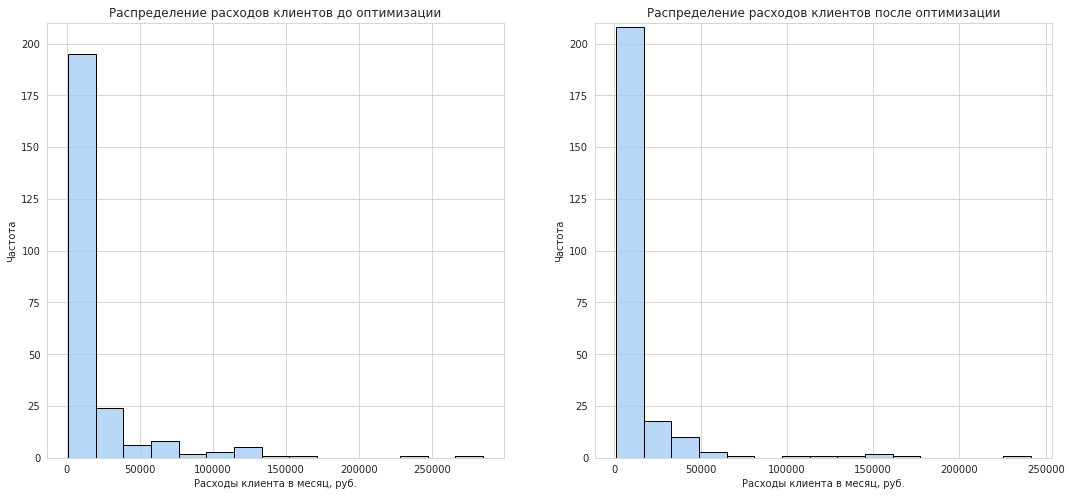

In [59]:
plt.figure(figsize=(18,8))

for i, j in enumerate([(payment_res['monthly_before'], 'до'), (payment_res['monthly_after'], 'после')]):
    plt.subplot (1, 2, i+1)
    sns.histplot(j[0], bins=15,ec='black')
    plt.title(f'Распределение расходов клиентов {j[1]} оптимизации')
    plt.xlabel('Расходы клиента в месяц, руб.')
    plt.ylabel('Частота')
    plt.ylim(0, 210)

Исходя из графика, можно сделать вывод, что расходы клиентов в целом стали меньше:
- "хвост" графика сократился;
- кол-во счетов на суммы свыше 50 000 руб. стало меньше;
- кол-во клиентов, которые в среднем платят менее 50 000 руб. в месяц стало значительно больше

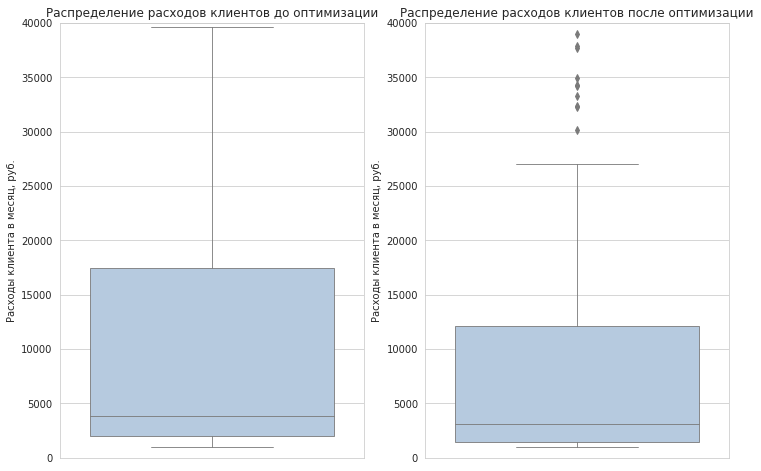

In [60]:
plt.figure(figsize=(12,8))

for i, j in enumerate([('monthly_before', 'до'), ('monthly_after', 'после')]):
    plt.subplot(1, 2, i+1)
    sns.boxplot(data=payment_res, y=j[0], saturation=.5, linewidth=.85)
    plt.title(f'Распределение расходов клиентов {j[1]} оптимизации')
    plt.ylabel('Расходы клиента в месяц, руб.')
    plt.ylim(0, 40000)

In [61]:
payment_res[['monthly_before', 'monthly_after']].describe()

,monthly_before,monthly_after
count,247.000000,247.000000
mean,17565.478543,12618.476113
std,35744.843896,27799.868239
min,1000.000000,1000.000000
25%,2000.000000,1486.400000
50%,3847.500000,3149.600000
75%,17433.950000,12157.900000
max,285207.000000,241420.000000


Боксплот также свидетельствует о том, что расходы клиентов сократились:
- Медианное значение среднего чека в месяц сократилось (c 3849 руб. до 3150 руб.);
- отклонение от медианы стало значительно меньше, так как большое количество клиентов, которые платили большие суммы на текущих тарифах, перешли на более оптимальные
- до оптимизации 75% пользователей не более 17 444 руб., а после оптимизации - не более 12 157 руб.

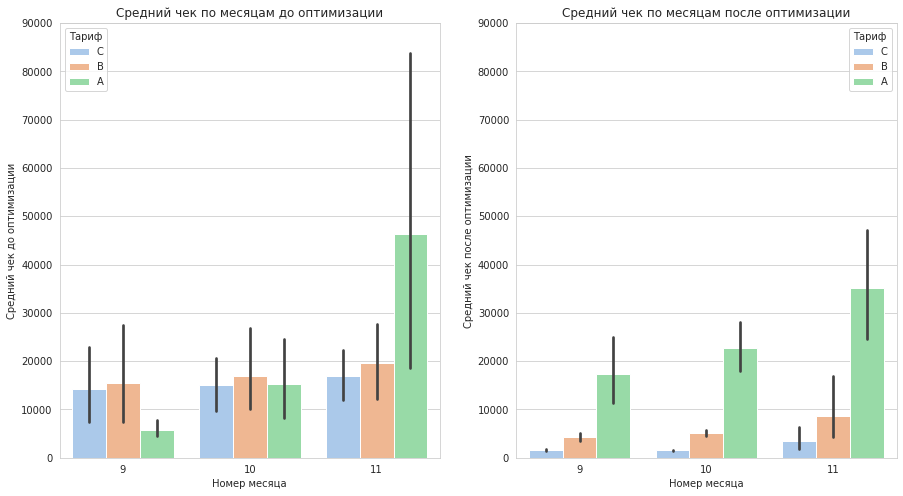

In [62]:
plt.figure(figsize=(15,8))

for i, j in enumerate([('current_tarif', 'tariff_plan', 'до'), ('after_opt', 'after_opt_tarif', 'после')]):
    plt.subplot(1, 2, i+1)
    sns.barplot(data=payment_monthly.sort_values(by=j[0]), x='month', y=j[0],  hue=j[1])
    
    plt.title(f'Средний чек по месяцам {j[2]} оптимизации')
    plt.xlabel('Номер месяца')
    plt.ylabel(f'Средний чек {j[2]} оптимизации')
    plt.legend(title="Тариф")
    
    plt.ylim(0, 90000)

В динамике средний чек все так же растет, однако:
- после оптимизации самый большой средний чек у клиентов с тарифа А, тогда как до оптимизации он был ниже всего в 2-х из 3-х месяцев;
- отклонение снизилось на каждом из тарифов и теперь крупные пользователи распределены по выгодным тарифам и не искажают динамику выручки;
- в целом средний чек на всем периоде после оптимизации снизился

**Распределение пользователей по тарифам**

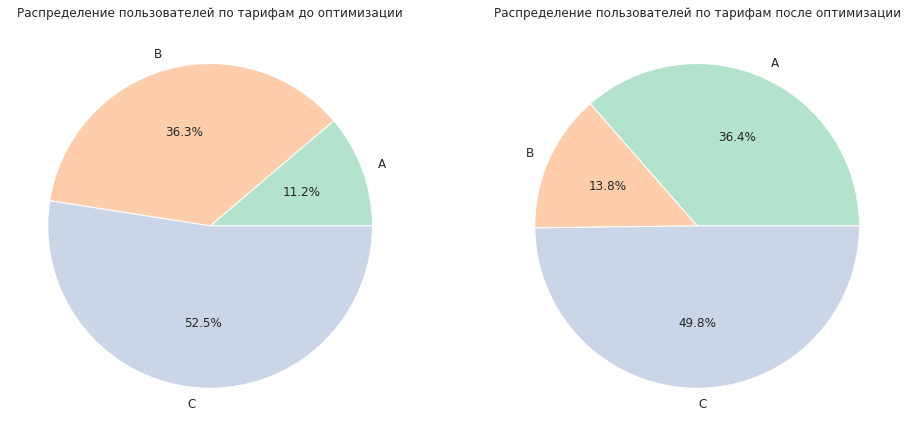

In [63]:
plt.figure(figsize=(16,10))

for i, j in enumerate([(data_tarif,'tariff_plan', 'до'), (payment_res, 'after_opt_tarif', 'после')]):
    
    plt.subplot(1, 2, i+1)
    
    plt.pie(j[0].pivot_table(index=j[1], values='user_id', aggfunc='nunique').reset_index()['user_id'],
        labels = ['A', 'B', 'C'],
        autopct='%.1f%%',
        textprops={'size': 'large'},
        colors = sns.color_palette('Pastel2')[:])
    
    plt.title(f'Распределение пользователей по тарифам {j[2]} оптимизации')

- После оптимизации значительно выросла доля клиентов с тарифом А (с 11,2% до 36,4%), а доля клиентов с тарифом В, наоборот, значительно сократилась (с 36,3% до 13,8%)
- доля клиентов с тарифом С незначительно сократилась (с 52,5% до 49,8%), однако продолжает составлять почти половину всех клиентов;
- экономия у клиентов в основном достигается путем перехода на более дорогой тариф по анбонентской плате.

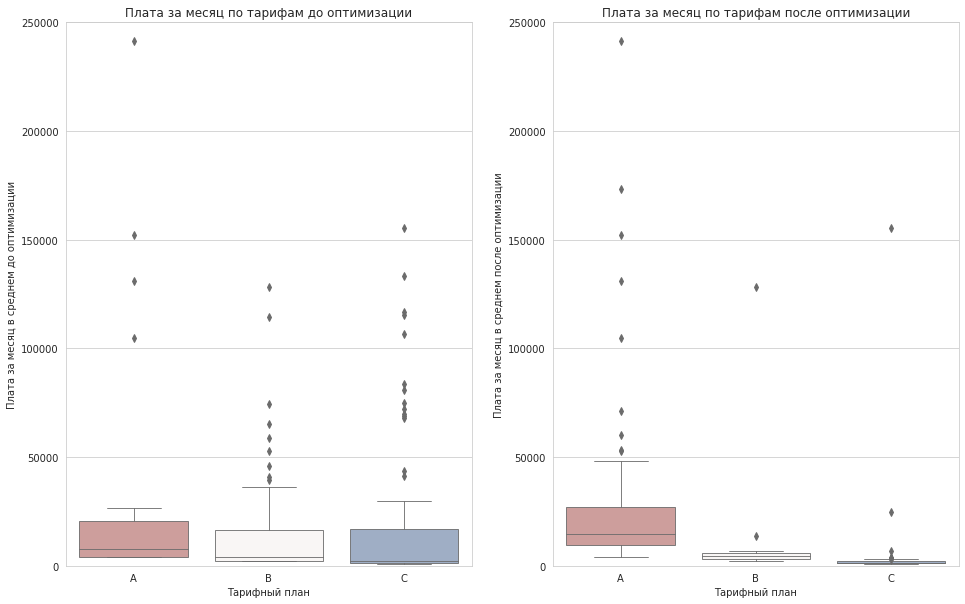

In [64]:
plt.figure(figsize=(16,10))
for i, j in enumerate([('tariff_plan', 'monthly_before', 'до'), ('after_opt_tarif', 'monthly_after', 'после')]):
    plt.subplot(1, 2, i+1)
    sns.boxplot(data=payment_res.sort_values(by=j[0]),
                x=j[0],
                y=j[1],
                linewidth=.85,
                palette='vlag_r',
                saturation=.8)
    plt.title(f'Плата за месяц по тарифам {j[2]} оптимизации')
    plt.xlabel('Тарифный план')
    plt.ylabel(f'Плата за месяц в среднем {j[2]} оптимизации')
    plt.ylim(0, 250000)


Заметно убрались выбросы, так как те пользователи, которые платили много на тарифах B и C перешли на более дорогие (по абонентской плате) тарифы. В тарифе А как раз выбросы немного увеличились, так как именно на этот тариф перешли пользователи с особо большими расходами минут, так как этот тариф располагает более выгодными условиями именно на минуты сверх лимита,на минуты не внутренних звонков и т.д.
На тарифе С много клиентов и по боксплоту как раз видно, что теперь у них плата в одном более-мене определенном диапазоне

**Изменения в выручке**

In [65]:
print('Средняя выручка в месяц до оптимизации тарифов:', payment_res['monthly_before'].sum())

print('\nСредняя выручка в месяц после оптимизации тарифов:', payment_res['monthly_after'].sum())

print('\nПроцентное изменение в средней выручке в месяц после оптимизации тарифов:',
      round((payment_res['monthly_after'].sum() / payment_res['monthly_before'].sum() - 1) * 100, 1), '%')

Средняя выручка в месяц до оптимизации тарифов: 4338673.2

Средняя выручка в месяц после оптимизации тарифов: 3116763.5999999996

Процентное изменение в средней выручке в месяц после оптимизации тарифов: -28.2 %


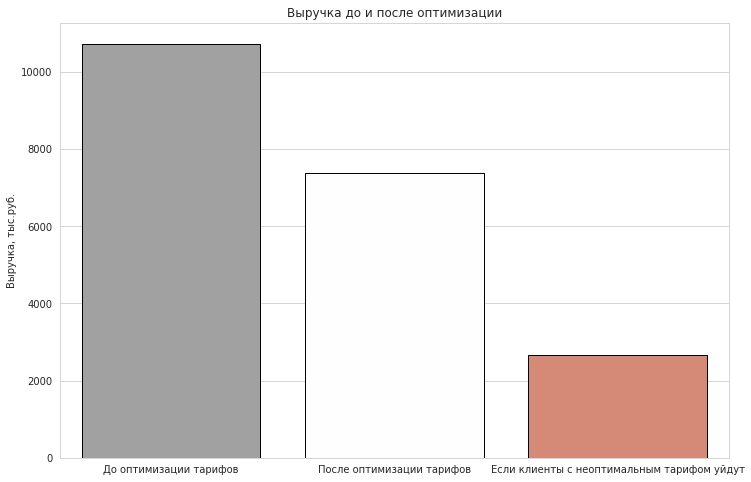

In [66]:
revenue = pd.DataFrame({'До оптимизации тарифов' : [payment_res['current_tarif'].sum()/1000],
                        'После оптимизации тарифов':[payment_res['after_opt'].sum()/1000],
                       'Если клиенты с неоптимальным тарифом уйдут':
                        payment_pivot[payment_pivot['is_not_optimal'] == False]['current_tarif'].sum()/1000}).T.reset_index()

revenue.columns = ['is_opt', 'revenue']

plt.figure(figsize=(12,8))

sns.barplot(data=revenue, y='revenue', x='is_opt', palette='RdGy_r', ec='black')

plt.title('Выручка до и после оптимизации')
plt.xlabel('')
plt.ylabel('Выручка, тыс.руб.')

plt.show()

После оптимизации тарифов средняя выручка в месяц упала на 30%, что довольно много, однако если предположить, что клиенты с неоптимальным тарифом уйдут, то бизнес потеряет намного больше (около 75%)

Для того, чтобы снизить потери при переходе клиентов на оптимальные тарифы рекомендуется пересмотреть тарифную сетку, предложить клиентам другие условия. Также стоит наладить систему защиты для того, чтобы несколько операторов не могли работать через один аккаунт, и клиенты не смогли экономить на плате за операторов.

**Вывод**

Во время исследовательского анализа данных было выявлено:
- Данные представлены за период со 2 августа 2019 года по 28 ноября 2019 года, при этом активный период анализа: с сентября по декабрь 2019 года;
- в данных есть аномалии по продолжительности и количеству звонков. Аномалии были удалены, они составили 3% всех данных за активный период исследования;
- активный пользователь - тот, кто совершал звонки, как минимум, последние 15 дней активного периода анализа. Количество неактивных пользователей - 56;
- клиентов с неоптимальными тарифами всего 121 (49% от всех активных пользователей)
- средняя выручка в месяц упадет на 27%, если все пользователи с неоптимальными тарифами перейдут на оптимальные, однако если все пользователи с неоптимальными тарифами уйдут к конкурентам, то потери могут достичь 75%
- после оптимизации тарифов количество клиентов с тарифом А вырастет(36%), а с тарифом В - упадет(14%), клиентов с тарифом С станет незначительно меньше и они все так же будут составлять почти половину от всех пользователей



## Проверка гипотез <a id ='9'></a>

### Гипотеза о равенстве средних чеков на разных тарифных планах <a id ='10'></a>

**Нулевая гипотеза Н0**: Между средними чеками на тарифных планах А и C нет значимой разницы

**Альтернативная гипотеза Н1**: Между средними чеками на тарифных планах А и C есть значимая разница

Гипотезы будем проверять с помощью непараметрического теста Манна-Уитни, так как в данных наблюдаются выбросы, сильно сдвигающие параметрические результаты - `scipy.stats.mannwhitneyu()`

In [72]:
# уровень стат. значимости
alpha = 0.05

result = stats.mannwhitneyu(payment_monthly['A'], payment_monthly['B'])

# выводим p-value
print('p-value:', result.pvalue)
# проверям p-value и принимаем решение
if result.pvalue < alpha:
    print('Нулевая гипотеза отвергается.')
else:
    print('Нельзя отвергнуть нулевую гипотезу.')


p-value: 4.8361747347691e-21
Нулевая гипотеза отвергается.


Полученное значение p-value нам говорит о том, что при условии, что средние чеки на тарифных планах А и С разные, получить такое или большее различие случайно можно с очень маленькой вероятностью (ниже 0.1%). Этой вероятность слишком мала для того, чтобы делать вывод об отсутствии значимой разницы между средними чеками на тарифных планах А и С.

### Вторая гипотеза о равенстве средней выручки на клиента до и после оптимизации тарифов <a id ='11'></a>

**Нулевая гипотеза H0**: Средняя выручка на клиента до и после оптимизации тарифов не имеет значимой разницы

**Альтернаятиваня гипотеза H1**: Средняя выручка на клиента до и после оптимизации тарифов значимо различается

Гипотезу будем проверять с помощью t-теста для гипотез о равенстве средних для зависимых выборок - `scipy.stats.ttest_rel()`

In [68]:
result = stats.ttest_rel(payment_res['monthly_before'], payment_res['monthly_after'])

# выводим p-value
print('p-value:', result.pvalue)
# проверям p-value и принимаем решение
if result.pvalue < alpha:
    print('Нулевая гипотеза отвергается.')
else:
    print('Нельзя отвергнуть нулевую гипотезу.')

p-value: 1.0198516603181089e-08
Нулевая гипотеза отвергается.


Полученное значение p-value нам говорит о том, что при условии, что средняя выручка на клиента до и после отпимизации значимо различается, получить такое или большее различие случайно можно с очень маленькой вероятностью (ниже 0.01%). Эта вероятность слишком мала для того, чтобы делать вывод об отсутствии разницы между средней выручкой на клиента до и после оптимизаии тарифов.


## Презентация <a id ='12'></a>

Ссылка на презентацию: <https://disk.yandex.ru/i/f624c05y09s8KQ>

## Общий вывод<a id ='13'></a>

Во время проекта было выполнено следующее:

**1. Обзор и предобработка данных**

На этом этапе было выполнено:
- Датафрейм с информацией о вызовах очищен от дубликатов. Пропуски в столбце `iternal` удалены, а в столбце `operator_id` оставлены (пропуски появляются, так как не назначается оператор для входящих пропущенных вызовов). Данные в столбце `iternal` приведены к типу данных `bool`, в столбце `date` - к `datetime.date`;
- В датафрейме с информацией о клиентах столбец `date_start` приведен к типу данных `datetime.date`

**2. Исследовательский анализ данных**

Было выявлено:
- Данные представлены за период со 2 августа 2019 года по 28 ноября 2019 года, при этом активный период анализа: с сентября по декабрь 2019 года;
- в данных есть аномалии по продолжительности и количеству звонков. Аномалии были удалены, они составили 3% всех данных за активный период исследования;
- активный пользователь - тот, кто совершал звонки, как минимум, последние 15 дней активного периода анализа. Количество неактивных пользователей - 56;
- клиентов с неоптимальными тарифами всего 121 (49% от всех активных пользователей)
- средняя выручка в месяц упадет на 27%, если все пользователи с неоптимальными тарифами перейдут на оптимальные, однако если все пользователи с неоптимальными тарифами уйдут к конкурентам, то потери могут достичь 75%
- после оптимизации тарифов количество клиентов с тарифом А вырастет(36%), а с тарифом В - упадет(14%), клиентов с тарифом С станет незначительно меньше и они все так же будут составлять почти половину от всех пользователей


**3. Проверка гипотез**

- Первая гипотеза о равенсве средних чеков на тарифах А и С была отвергнута в пользу альтернативной: средние чеки на тарифах А и С значимо различаются
- Вторая гипотеза о равенстве средней выручки до и после оптимизации тарифов также была отвергнута в пользу альтернативной: средняя выручка на клиента до и после оптимизации значимо различается

***
- Всего **49% (121) активных клиентов с неоптимальными тарифами**, которым будет целесообразно преложить сменить тариф
- При переходе всех этих клиентов на оптимальный тариф **средняя выручка в месяц упадет на 27%**
- После оптимизации клиентов с тарифом А станет больше на 25,2%, а клиентов с тарифом В станет меньше на 22,5%, клиентов с тарифом С после оптимизации всего 49%
- Для снижения потерь после перехода клиентов на оптимальные тарифы **рекомендуется сменить тарифную сетку и проверить/наладить систему защиты** (чтобы несколько операторов не могло сидеть через 1 аккаунт)
***